## **Transfer Learning with VGG16 — Cats vs Dogs Classification**

This notebook demonstrates how to apply **Transfer Learning** using the **VGG16** convolutional neural network for binary image classification on a Cats vs Dogs dataset.
It covers the full deep-learning workflow—from data preprocessing to model evaluation and visualization.

### **Key Features**
* Loads and preprocesses image datasets using `tensorflow_datasets`.
* Uses **VGG16** (pretrained on ImageNet) as a feature extractor.
* Adds a custom classification head for binary prediction.
* Trains the model with callbacks (EarlyStopping, ReduceLROnPlateau, ModelCheckpoint).
* Evaluates performance using accuracy, loss curves, and prediction examples.

### **Model Performance**
* Achieved **~98% validation accuracy** with a stable loss curve.
* Includes clear visualizations of training/validation accuracy and loss.

### **Extra Tools**
* Functions to load and predict single images.
* Displaying a batch of predictions from the test set.
* Improved heatmap visualization for model interpretability.

### **Purpose**
This notebook is designed for learners and practitioners who want to:

* Understand Transfer Learning using Keras.
* Train a strong image classifier with minimal data.
* Visualize how CNNs “see” images.
* Experiment with fine-tuning, augmentation, and model improvements.

---


# 1. Importing Libraries
Load TensorFlow, Keras, Matplotlib, NumPy, and other required packages.

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

from sklearn.metrics import confusion_matrix
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt


# 2. Dataset Loading

In [3]:
# Set the data directory to a location where you have write permissions
data_dir = os.path.expanduser('~/tensorflow_datasets')
os.makedirs(data_dir, exist_ok=True)

# Load dataset
train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    split=["train[:20%]", "train[20%:25%]", "train[25%:30%]"],
    as_supervised=True,  # Include labels
    data_dir=data_dir,
)

print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print("Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds))
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))

Number of training samples: 4652
Number of validation samples: 1164
Number of test samples: 1163


# 3. Visualizing Sample Images
Show a few training samples to verify the dataset.

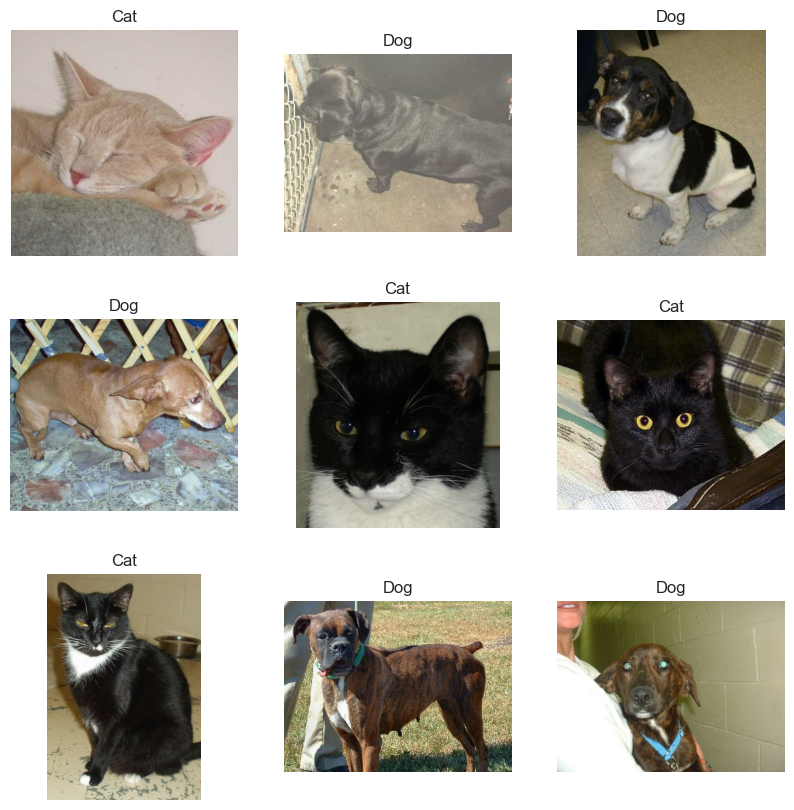

In [4]:
sub_train_ds = train_ds.shuffle(100).take(9)

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(sub_train_ds):
    plt.subplot(3, 3, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image)
    plt.title("Cat" if int(label) == 0 else "Dog")
    plt.axis('off')

# 4. Data Preprocessing & Augmentation

Resizing, normalization, data augmentation, batching, shuffling, and preparing tf.data pipelines

In [5]:
IMG_SIZE = (224, 224)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, IMG_SIZE), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, IMG_SIZE), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, IMG_SIZE), y))

In [6]:
BATCH_SIZE = 32

train_ds = train_ds.shuffle(500).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
validation_ds = validation_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [7]:
data_augmentation = Sequential(
    [layers.RandomFlip("horizontal"),
     layers.RandomRotation(0.1),
     layers.RandomRotation(0.1),
     layers.RandomZoom(0.2),
     layers.RandomContrast(0.2)]
)

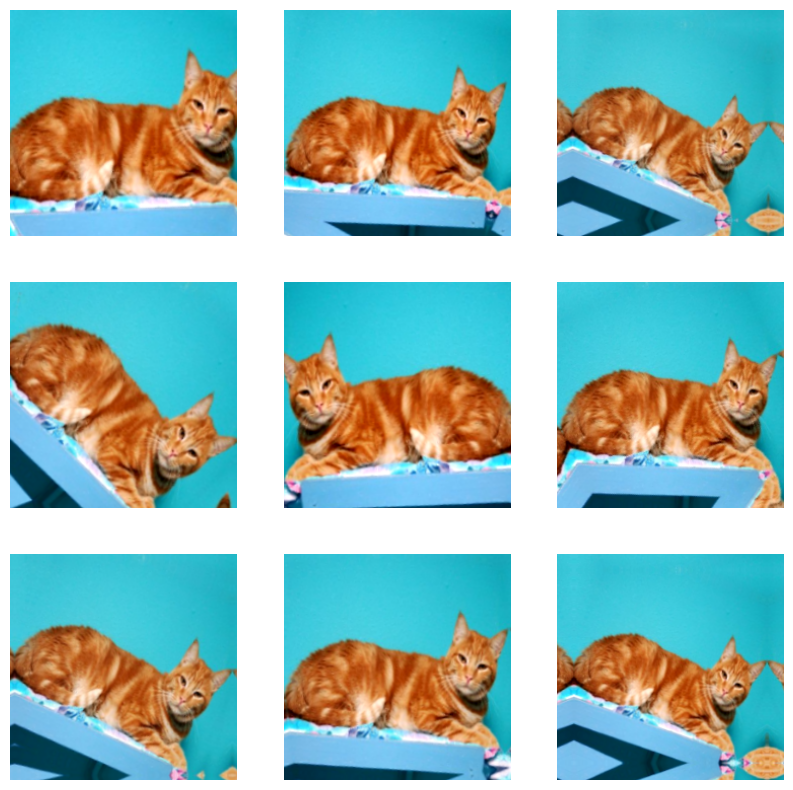

In [10]:
sub_train_ds = train_ds.shuffle(10).take(1)

for images, labels in sub_train_ds:
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.axis("off")

In [11]:
def preprocess(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = preprocess_input(image)  # IMPORTANT for VGG16
    return image, label


train_ds = train_ds.map(preprocess)
validation_ds = validation_ds.map(preprocess)
test_ds = test_ds.map(preprocess)

# 5. Building the VGG16 Transfer Learning Model and Compiling the Model

* Load pretrained VGG16
* Freeze base layers
* Add custom Dense layers for classification

In [12]:
base_model = VGG16(
    weights="imagenet", # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False, # Do not include the ImageNet classifier at the top.
)
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Freeze base model initially
base_model.trainable = False

# Build model
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)

x = base_model(x, training=False)

x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)

# Compile model
model.compile(
    optimizer=Adam(1e-4),
    loss=BinaryCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

# 6. Training the Model
Run model.fit() and store training history.

In [15]:
# Callbacks
callbacks = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=6,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'best_vgg16_cats_dogs.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("=== PHASE 1: Training with frozen base model ===")
# Phase 1: Train with frozen base model
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=validation_ds,
    callbacks=callbacks,
    verbose=1
)

=== PHASE 1: Training with frozen base model ===
Epoch 1/10
 61/146 ━━━━━━━━━━━━━━━━━━━━ 5:19 4s/step - accuracy: 0.6487 - loss: 2.5203

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6969 - loss: 1.8527
Epoch 1: val_accuracy improved from -inf to 0.94845, saving model to best_vgg16_cats_dogs.keras
146/146 ━━━━━━━━━━━━━━━━━━━━ 652s 4s/step - accuracy: 0.6972 - loss: 1.8479 - val_accuracy: 0.9485 - val_loss: 0.6148 - learning_rate: 1.0000e-04
Epoch 2/10
 62/146 ━━━━━━━━━━━━━━━━━━━━ 5:00 4s/step - accuracy: 0.7944 - loss: 0.5322

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8027 - loss: 0.5177
Epoch 2: val_accuracy improved from 0.94845 to 0.96048, saving model to best_vgg16_cats_dogs.keras
146/146 ━━━━━━━━━━━━━━━━━━━━ 645s 4s/step - accuracy: 0.8027 - loss: 0.5176 - val_accuracy: 0.9605 - val_loss: 0.5297 - learning_rate: 1.0000e-04
Epoch 3/10
 62/146 ━━━━━━━━━━━━━━━━━━━━ 4:57 4s/step - accuracy: 0.8650 - loss: 0.4464

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8610 - loss: 0.4447
Epoch 3: val_accuracy improved from 0.96048 to 0.96993, saving model to best_vgg16_cats_dogs.keras
146/146 ━━━━━━━━━━━━━━━━━━━━ 642s 4s/step - accuracy: 0.8610 - loss: 0.4447 - val_accuracy: 0.9699 - val_loss: 0.4549 - learning_rate: 1.0000e-04
Epoch 4/10
 61/146 ━━━━━━━━━━━━━━━━━━━━ 5:03 4s/step - accuracy: 0.8632 - loss: 0.4206

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8680 - loss: 0.4198
Epoch 4: val_accuracy improved from 0.96993 to 0.97251, saving model to best_vgg16_cats_dogs.keras
146/146 ━━━━━━━━━━━━━━━━━━━━ 642s 4s/step - accuracy: 0.8680 - loss: 0.4198 - val_accuracy: 0.9725 - val_loss: 0.4236 - learning_rate: 1.0000e-04
Epoch 5/10
 61/146 ━━━━━━━━━━━━━━━━━━━━ 5:03 4s/step - accuracy: 0.8703 - loss: 0.4071

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8754 - loss: 0.4045
Epoch 5: val_accuracy did not improve from 0.97251
146/146 ━━━━━━━━━━━━━━━━━━━━ 644s 4s/step - accuracy: 0.8755 - loss: 0.4045 - val_accuracy: 0.9691 - val_loss: 0.3984 - learning_rate: 1.0000e-04
Epoch 6/10
 62/146 ━━━━━━━━━━━━━━━━━━━━ 4:57 4s/step - accuracy: 0.8839 - loss: 0.3956

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8859 - loss: 0.3920
Epoch 6: val_accuracy improved from 0.97251 to 0.97938, saving model to best_vgg16_cats_dogs.keras
146/146 ━━━━━━━━━━━━━━━━━━━━ 640s 4s/step - accuracy: 0.8859 - loss: 0.3920 - val_accuracy: 0.9794 - val_loss: 0.3816 - learning_rate: 1.0000e-04
Epoch 7/10
 61/146 ━━━━━━━━━━━━━━━━━━━━ 5:01 4s/step - accuracy: 0.8745 - loss: 0.3941

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8866 - loss: 0.3859
Epoch 7: val_accuracy did not improve from 0.97938
146/146 ━━━━━━━━━━━━━━━━━━━━ 643s 4s/step - accuracy: 0.8867 - loss: 0.3859 - val_accuracy: 0.9716 - val_loss: 0.3673 - learning_rate: 1.0000e-04
Epoch 8/10
 59/146 ━━━━━━━━━━━━━━━━━━━━ 5:07 4s/step - accuracy: 0.8989 - loss: 0.3767

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9025 - loss: 0.3736
Epoch 8: val_accuracy did not improve from 0.97938
146/146 ━━━━━━━━━━━━━━━━━━━━ 641s 4s/step - accuracy: 0.9025 - loss: 0.3736 - val_accuracy: 0.9734 - val_loss: 0.3510 - learning_rate: 1.0000e-04
Epoch 9/10
 61/146 ━━━━━━━━━━━━━━━━━━━━ 5:01 4s/step - accuracy: 0.9020 - loss: 0.3668

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9076 - loss: 0.3656
Epoch 9: val_accuracy did not improve from 0.97938
146/146 ━━━━━━━━━━━━━━━━━━━━ 638s 4s/step - accuracy: 0.9076 - loss: 0.3656 - val_accuracy: 0.9794 - val_loss: 0.3568 - learning_rate: 1.0000e-04
Epoch 10/10
 62/146 ━━━━━━━━━━━━━━━━━━━━ 4:54 4s/step - accuracy: 0.9149 - loss: 0.3591

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9133 - loss: 0.3606
Epoch 10: val_accuracy did not improve from 0.97938
146/146 ━━━━━━━━━━━━━━━━━━━━ 638s 4s/step - accuracy: 0.9133 - loss: 0.3606 - val_accuracy: 0.9716 - val_loss: 0.3465 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 10.


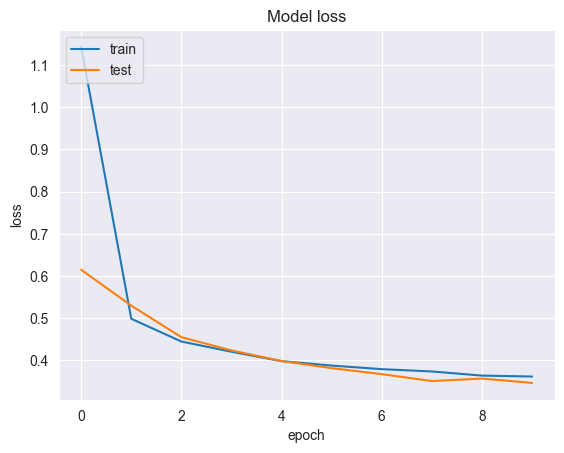

In [16]:
# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

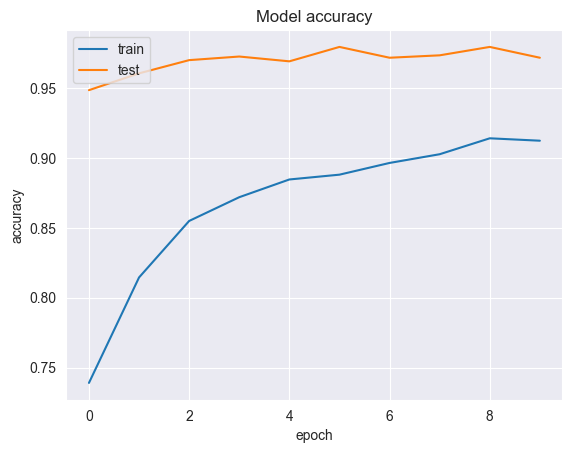

In [17]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
print("\n=== PHASE 2: Fine-tuning with unfrozen layers ===")
# Unfreeze last convolution block
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Recompile with lower learning rate
model.compile(
    optimizer=Adam(1e-5),  # smaller LR for fine-tuning
    loss=BinaryCrossentropy(label_smoothing=0.05),
    metrics=["accuracy"],
)

# Continue training
history_fine = model.fit(
    train_ds,
    epochs=30,
    initial_epoch=history.epoch[-1] + 1,
    validation_data=validation_ds,
    callbacks=callbacks,
    verbose=1
)


=== PHASE 2: Fine-tuning with unfrozen layers ===
Epoch 11/30
 62/146 ━━━━━━━━━━━━━━━━━━━━ 5:56 4s/step - accuracy: 0.9133 - loss: 0.3053

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9119 - loss: 0.3016
Epoch 11: val_accuracy did not improve from 0.97938
146/146 ━━━━━━━━━━━━━━━━━━━━ 664s 5s/step - accuracy: 0.9120 - loss: 0.3016 - val_accuracy: 0.9751 - val_loss: 0.2538 - learning_rate: 1.0000e-05
Epoch 12/30
 62/146 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - accuracy: 0.9240 - loss: 0.2734

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9257 - loss: 0.2738
Epoch 12: val_accuracy did not improve from 0.97938
146/146 ━━━━━━━━━━━━━━━━━━━━ 368s 3s/step - accuracy: 0.9257 - loss: 0.2738 - val_accuracy: 0.9699 - val_loss: 0.2477 - learning_rate: 1.0000e-05
Epoch 13/30
 62/146 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - accuracy: 0.9328 - loss: 0.2618

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9341 - loss: 0.2602
Epoch 13: val_accuracy did not improve from 0.97938
146/146 ━━━━━━━━━━━━━━━━━━━━ 367s 3s/step - accuracy: 0.9341 - loss: 0.2601 - val_accuracy: 0.9777 - val_loss: 0.2376 - learning_rate: 1.0000e-05
Epoch 14/30
 62/146 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - accuracy: 0.9385 - loss: 0.2495

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9393 - loss: 0.2513
Epoch 14: val_accuracy improved from 0.97938 to 0.98024, saving model to best_vgg16_cats_dogs.keras
146/146 ━━━━━━━━━━━━━━━━━━━━ 367s 3s/step - accuracy: 0.9393 - loss: 0.2513 - val_accuracy: 0.9802 - val_loss: 0.2268 - learning_rate: 1.0000e-05
Epoch 15/30
 62/146 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - accuracy: 0.9374 - loss: 0.2551

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9453 - loss: 0.2469
Epoch 15: val_accuracy did not improve from 0.98024
146/146 ━━━━━━━━━━━━━━━━━━━━ 367s 3s/step - accuracy: 0.9453 - loss: 0.2468 - val_accuracy: 0.9751 - val_loss: 0.2381 - learning_rate: 1.0000e-05
Epoch 16/30
 62/146 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - accuracy: 0.9413 - loss: 0.2408

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9482 - loss: 0.2353
Epoch 16: val_accuracy did not improve from 0.98024
146/146 ━━━━━━━━━━━━━━━━━━━━ 367s 3s/step - accuracy: 0.9482 - loss: 0.2352 - val_accuracy: 0.9682 - val_loss: 0.2426 - learning_rate: 1.0000e-05
Epoch 17/30
 62/146 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - accuracy: 0.9524 - loss: 0.2312

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9556 - loss: 0.2271
Epoch 17: val_accuracy improved from 0.98024 to 0.98110, saving model to best_vgg16_cats_dogs.keras
146/146 ━━━━━━━━━━━━━━━━━━━━ 367s 3s/step - accuracy: 0.9556 - loss: 0.2271 - val_accuracy: 0.9811 - val_loss: 0.2221 - learning_rate: 1.0000e-05
Epoch 18/30
 62/146 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - accuracy: 0.9523 - loss: 0.2367

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9564 - loss: 0.2291
Epoch 18: val_accuracy did not improve from 0.98110
146/146 ━━━━━━━━━━━━━━━━━━━━ 366s 3s/step - accuracy: 0.9564 - loss: 0.2290 - val_accuracy: 0.9725 - val_loss: 0.2315 - learning_rate: 1.0000e-05
Epoch 19/30
 62/146 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - accuracy: 0.9554 - loss: 0.2291

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9577 - loss: 0.2256
Epoch 19: val_accuracy improved from 0.98110 to 0.98196, saving model to best_vgg16_cats_dogs.keras
146/146 ━━━━━━━━━━━━━━━━━━━━ 367s 3s/step - accuracy: 0.9577 - loss: 0.2256 - val_accuracy: 0.9820 - val_loss: 0.2199 - learning_rate: 1.0000e-05
Epoch 20/30
 63/146 ━━━━━━━━━━━━━━━━━━━━ 2:53 2s/step - accuracy: 0.9673 - loss: 0.2175

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9663 - loss: 0.2131
Epoch 20: val_accuracy did not improve from 0.98196
146/146 ━━━━━━━━━━━━━━━━━━━━ 367s 3s/step - accuracy: 0.9662 - loss: 0.2131 - val_accuracy: 0.9596 - val_loss: 0.2601 - learning_rate: 1.0000e-05
Epoch 21/30
 62/146 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - accuracy: 0.9504 - loss: 0.2283

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9580 - loss: 0.2183
Epoch 21: val_accuracy did not improve from 0.98196
146/146 ━━━━━━━━━━━━━━━━━━━━ 367s 3s/step - accuracy: 0.9581 - loss: 0.2182 - val_accuracy: 0.9691 - val_loss: 0.2275 - learning_rate: 1.0000e-05
Epoch 22/30
 62/146 ━━━━━━━━━━━━━━━━━━━━ 2:55 2s/step - accuracy: 0.9692 - loss: 0.2060

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9690 - loss: 0.2058
Epoch 22: ReduceLROnPlateau reducing learning rate to 2.9999999242136253e-06.

Epoch 22: val_accuracy did not improve from 0.98196
146/146 ━━━━━━━━━━━━━━━━━━━━ 369s 3s/step - accuracy: 0.9690 - loss: 0.2058 - val_accuracy: 0.9674 - val_loss: 0.2346 - learning_rate: 1.0000e-05
Epoch 23/30
 62/146 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - accuracy: 0.9715 - loss: 0.2073

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9708 - loss: 0.2061
Epoch 23: val_accuracy did not improve from 0.98196
146/146 ━━━━━━━━━━━━━━━━━━━━ 369s 3s/step - accuracy: 0.9708 - loss: 0.2060 - val_accuracy: 0.9777 - val_loss: 0.2229 - learning_rate: 3.0000e-06
Epoch 24/30
 62/146 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - accuracy: 0.9666 - loss: 0.2068

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9677 - loss: 0.2063
Epoch 24: val_accuracy did not improve from 0.98196
146/146 ━━━━━━━━━━━━━━━━━━━━ 370s 3s/step - accuracy: 0.9677 - loss: 0.2063 - val_accuracy: 0.9768 - val_loss: 0.2249 - learning_rate: 3.0000e-06
Epoch 25/30
 62/146 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - accuracy: 0.9765 - loss: 0.1999

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9736 - loss: 0.2004
Epoch 25: ReduceLROnPlateau reducing learning rate to 8.999999636216671e-07.

Epoch 25: val_accuracy did not improve from 0.98196
146/146 ━━━━━━━━━━━━━━━━━━━━ 370s 3s/step - accuracy: 0.9736 - loss: 0.2003 - val_accuracy: 0.9794 - val_loss: 0.2212 - learning_rate: 3.0000e-06
Epoch 25: early stopping
Restoring model weights from the end of the best epoch: 19.


# 7. Training Results Visualization

Plot accuracy and loss curves for histories.

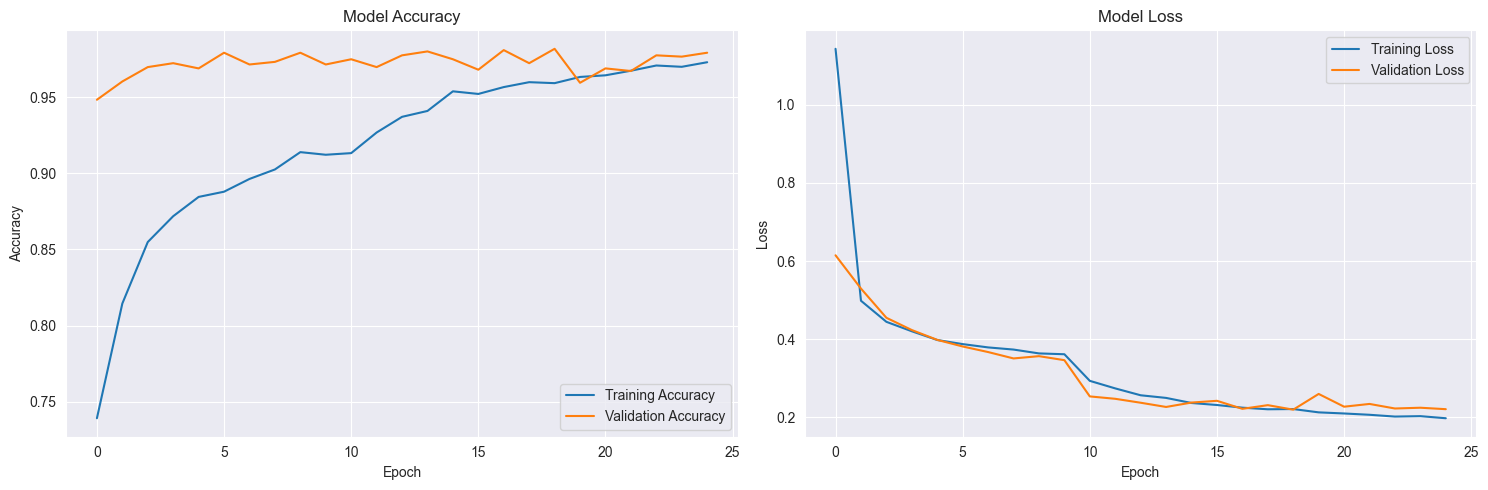

37/37 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.9787 - loss: 0.2213
Final Validation Accuracy: 0.9820
Final Validation Loss: 0.2199


In [23]:
# Combine histories
def combine_histories(hist1, hist2):
    combined_history = {}
    for key in hist1.history.keys():
        combined_history[key] = hist1.history[key] + hist2.history[key]
    return combined_history

combined_history = combine_histories(history, history_fine)

# Plot results
def plot_results(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Accuracy
    ax1.plot(history['accuracy'], label='Training Accuracy')
    ax1.plot(history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Loss
    ax2.plot(history['loss'], label='Training Loss')
    ax2.plot(history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


plot_results(combined_history)

final_loss, final_accuracy = model.evaluate(validation_ds)
print(f"Final Validation Accuracy: {final_accuracy:.4f}")
print(f"Final Validation Loss: {final_loss:.4f}")


37/37 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.9758 - loss: 0.2220
0.21652956306934357 0.980223536491394
37/37 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step


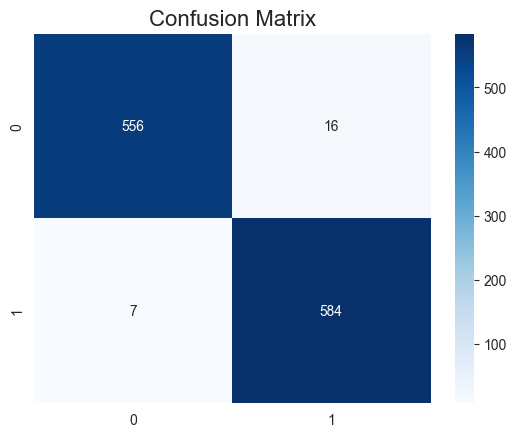

In [22]:
# Predictions
pred = model.predict(test_ds)
pred_labels = (pred > 0.5).astype(int)

# True labels
true_labels = np.concatenate([y for x, y in test_ds], axis=0)

# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)

plt.title("Confusion Matrix", fontsize=16)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()

# 8. Visualizing Predictions

Show sample predictions (10 images with predicted label vs true label).

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step


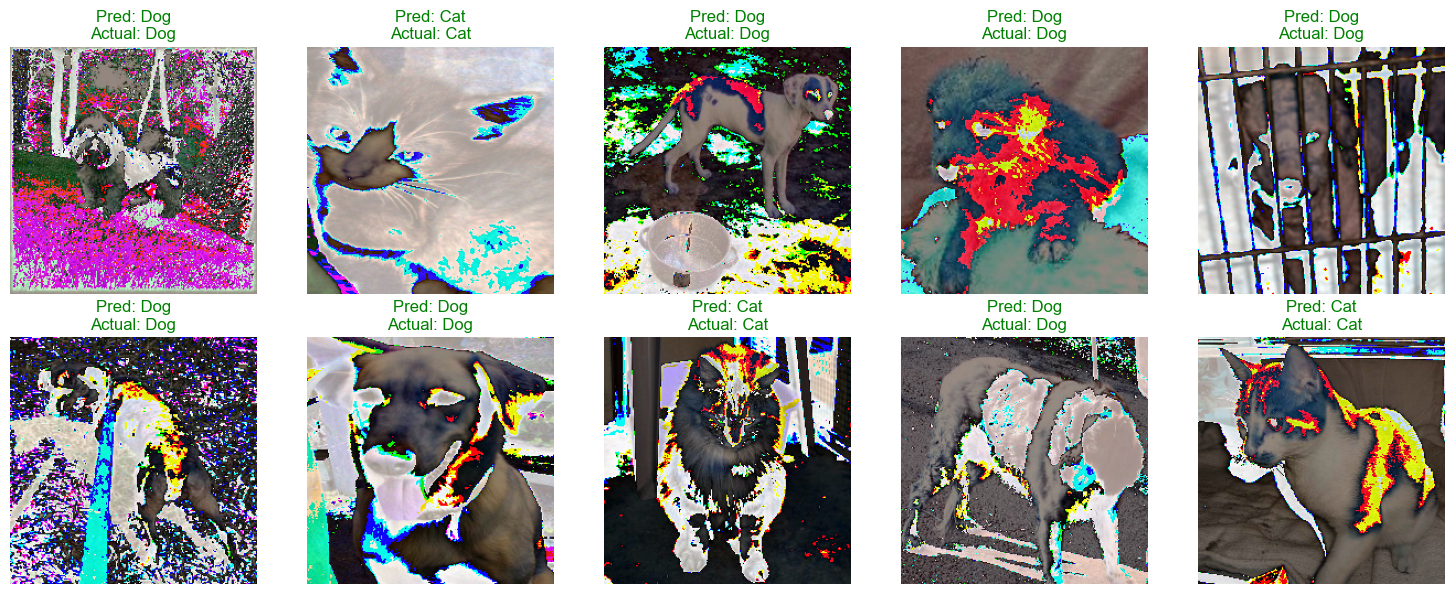

In [21]:
images_batch, labels_batch = next(iter(test_ds))

images_10 = images_batch[:10]
labels_10 = labels_batch[:10]

pred = model.predict(images_10)

# Convert probability → class: 0=Cat, 1=Dog
pred_labels = (pred > 0.5).astype(int).flatten()

# Display images with predicted & actual labels
plt.figure(figsize=(15, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images_10[i].numpy().astype("uint8"))
    plt.axis("off")
    predicted = "Dog" if pred_labels[i] == 1 else "Cat"
    actual = "Dog" if labels_10[i] == 1 else "Cat"
    color = "green" if pred_labels[i] == labels_10[i] else "red"
    plt.title(f"Pred: {predicted}\nActual: {actual}", color=color)

plt.tight_layout()
plt.show()

---

## **Conclusion**

In this project, I successfully applied **Transfer Learning with VGG16** to classify Cats vs Dogs images with high accuracy.
By leveraging pretrained ImageNet features and adding a custom classification head, the model achieved strong validation performance and stable training behavior.
Visualization tools like Grad-CAM provided valuable insights into how the network interprets images.
Overall, this workflow demonstrates an efficient and powerful approach for building image classifiers with limited data, and it can be extended or fine-tuned for many other computer vision tasks.
